In [2]:
import yfinance as yf
import pandas as pd

# Define time period
end_date = "2023-09-27"
start_date = "2015-09-27"

# Load S&P 500 tickers
sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tickers = pd.read_html(sp500_url)[0]['Symbol'].tolist()
tickers = [ticker.replace('.', '-') for ticker in tickers]  # Fix Yahoo Finance format

# Download data for all tickers in one call
snp500_data = yf.download(tickers, start=start_date, end=end_date, group_by="ticker")

# Save data
snp500_data.to_csv("snp500_data.csv")
print("Data download complete. Saved to snp500_data.csv")


[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
5 Failed downloads:
ERROR:yfinance:['SOLV', 'VLTO', 'SW', 'GEV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-09-27 -> 2023-09-27) (Yahoo error = "Data doesn\'t exist for startDate = 1443326400, endDate = 1695787200")')
ERROR:yfinance:['BSX']: ChunkedEncodingError(ProtocolError('Connection broken: IncompleteRead(1 bytes read, 1 more expected)', IncompleteRead(1 bytes read, 1 more expected)))


Data download complete. Saved to snp500_data.csv


In [3]:
snp500_data.head()

Ticker            CCI                                                   NI  \
Price            Open       High        Low      Close   Volume       Open   
Date                                                                         
2015-09-28  53.780188  54.116914  52.962419  53.306019  3599200  13.164253   
2015-09-29  53.450334  53.828295  53.086119  53.278534  1965600  13.134819   
2015-09-30  53.677095  54.240598  53.457192  54.199368  2400300  13.237838   
2015-10-01  54.219982  54.749122  53.793917  54.694145  2303900  13.760290   
2015-10-02  54.206254  54.955304  53.869528  54.934689  2488700  13.657270   

Ticker                                                ...       ROST  \
Price            High        Low      Close   Volume  ...       Open   
Date                                                  ...              
2015-09-28  13.245196  13.002368  13.120103  3034600  ...  44.595728   
2015-09-29  13.289346  13.039159  13.171611  2790700  ...  43.434426   
2015-09-30  13.664627  13.193687  13.649910  3570900  ...  44.019654   
2015-10-01  13.833873  13.488027  13.591044  3535800  ...  44.330559   
2015-10-02  13.855949  13.539535  13.848590  3600900  ...  43.452728   

Ticker                                                      WBA             \
Price            High        Low      Close   Volume       Open       High   
Date                                                                         
2015-09-28  45.327254  43.278980  43.425285  2582800  58.660842  58.950592   
2015-09-29  43.827622  42.949791  43.489292  2335300  57.087922  57.846794   
2015-09-30  44.650599  43.681324  44.321411  2875900  57.136217  57.453563   
2015-10-01  44.988935  43.251556  43.763626  4039300  57.653612  58.481471   
2015-10-02  44.577451  43.086963  44.559162  2302000  57.481156  60.130314   

Ticker                                     
Price             Low      Close   Volume  
Date                                       
2015-09-28  56.542898  57.005119  4845500  
2015-09-29  56.191071  56.611900  4483000  
2015-09-30  56.563612  57.329384  3888300  
2015-10-01  56.984424  58.384888  4312700  
2015-10-02  57.067226  60.095818  4629800  

[5 rows x 2520 columns]

In [4]:
df=snp500_data.copy()

In [5]:
df.head()

Ticker            CCI                                                   NI  \
Price            Open       High        Low      Close   Volume       Open   
Date                                                                         
2015-09-28  53.780188  54.116914  52.962419  53.306019  3599200  13.164253   
2015-09-29  53.450334  53.828295  53.086119  53.278534  1965600  13.134819   
2015-09-30  53.677095  54.240598  53.457192  54.199368  2400300  13.237838   
2015-10-01  54.219982  54.749122  53.793917  54.694145  2303900  13.760290   
2015-10-02  54.206254  54.955304  53.869528  54.934689  2488700  13.657270   

Ticker                                                ...       ROST  \
Price            High        Low      Close   Volume  ...       Open   
Date                                                  ...              
2015-09-28  13.245196  13.002368  13.120103  3034600  ...  44.595728   
2015-09-29  13.289346  13.039159  13.171611  2790700  ...  43.434426   
2015-09-30  13.664627  13.193687  13.649910  3570900  ...  44.019654   
2015-10-01  13.833873  13.488027  13.591044  3535800  ...  44.330559   
2015-10-02  13.855949  13.539535  13.848590  3600900  ...  43.452728   

Ticker                                                      WBA             \
Price            High        Low      Close   Volume       Open       High   
Date                                                                         
2015-09-28  45.327254  43.278980  43.425285  2582800  58.660842  58.950592   
2015-09-29  43.827622  42.949791  43.489292  2335300  57.087922  57.846794   
2015-09-30  44.650599  43.681324  44.321411  2875900  57.136217  57.453563   
2015-10-01  44.988935  43.251556  43.763626  4039300  57.653612  58.481471   
2015-10-02  44.577451  43.086963  44.559162  2302000  57.481156  60.130314   

Ticker                                     
Price             Low      Close   Volume  
Date                                       
2015-09-28  56.542898  57.005119  4845500  
2015-09-29  56.191071  56.611900  4483000  
2015-09-30  56.563612  57.329384  3888300  
2015-10-01  56.984424  58.384888  4312700  
2015-10-02  57.067226  60.095818  4629800  

[5 rows x 2520 columns]

In [6]:
df.shape

(2013, 2520)

In [8]:
# Keep only the "Close" prices
df = df.xs('Close', axis=1, level=1)


In [9]:
df.head()

Ticker,CCI,NI,LOW,BEN,BLK,TJX,UNH,CSX,ED,CLX,...,NRG,CI,FTV,TEL,EQR,MGM,MO,LII,ROST,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-28,53.306019,13.120103,56.507683,23.881762,232.527084,30.308863,97.956299,7.538494,47.003147,87.949295,...,11.968584,124.022873,NaN,47.983101,44.074223,17.558449,29.733154,102.716759,43.425285,57.005119
2015-09-29,53.278534,13.171611,56.187901,23.660519,232.100067,30.479946,99.277443,7.523993,47.060276,88.218849,...,11.630988,123.556633,NaN,48.616108,45.445938,16.774508,29.515448,100.328003,43.489292,56.611900
2015-09-30,54.199368,13.649910,57.997162,24.246178,235.223465,31.331009,100.833267,7.802445,47.738693,88.965797,...,11.936432,125.906525,NaN,50.548950,46.416039,17.426220,29.607975,101.392662,44.321411,57.329384
2015-10-01,54.694145,13.591044,58.729279,24.129044,233.997864,31.059023,101.354774,7.840150,46.867455,88.850296,...,11.848016,126.288841,NaN,50.194458,46.508709,17.634008,29.510012,101.723671,43.763626,58.384888
2015-10-02,54.934689,13.848590,59.099545,24.571543,239.880966,31.313469,103.284363,7.921363,47.588718,90.043884,...,11.952508,129.226242,NaN,50.633339,47.009197,18.691866,29.858335,101.410515,44.559162,60.095818


In [11]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=81f2602222c4345d9dd906839e28f1516f6d3a3b876411474139d8c0cc1a613a
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [12]:
import pandas_ta as ta

# Create a new DataFrame for RSI values
rsi_df = df.apply(lambda x: ta.rsi(x, length=14), axis=0)

# Rename columns to indicate RSI values
rsi_df.columns = [f"{col}_RSI" for col in rsi_df.columns]

# Display the first few rows of the RSI DataFrame
rsi_df.head()


,CCI_RSI,NI_RSI,LOW_RSI,BEN_RSI,BLK_RSI,TJX_RSI,UNH_RSI,CSX_RSI,ED_RSI,CLX_RSI,...,NRG_RSI,CI_RSI,FTV_RSI,TEL_RSI,EQR_RSI,MGM_RSI,MO_RSI,LII_RSI,ROST_RSI,WBA_RSI
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
rsi_df.head(15)

,CCI_RSI,NI_RSI,LOW_RSI,BEN_RSI,BLK_RSI,TJX_RSI,UNH_RSI,CSX_RSI,ED_RSI,CLX_RSI,...,NRG_RSI,CI_RSI,FTV_RSI,TEL_RSI,EQR_RSI,MGM_RSI,MO_RSI,LII_RSI,ROST_RSI,WBA_RSI
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df = df.iloc[14:]
rsi_df = rsi_df.iloc[14:]


In [16]:
df.head()

Ticker,CCI,NI,LOW,BEN,BLK,TJX,UNH,CSX,ED,CLX,...,NRG,CI,FTV,TEL,EQR,MGM,MO,LII,ROST,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-16,56.116673,14.319530,61.245422,25.033558,261.602844,31.774078,104.283905,7.956172,47.860085,93.886513,...,12.073077,131.240463,NaN,53.477726,48.652794,20.354200,31.959202,105.356041,45.994793,60.806381
2015-10-19,56.735157,14.385756,62.031033,24.825327,259.270203,31.989040,104.935783,7.927168,47.795822,93.732513,...,11.896244,132.322174,NaN,53.494610,49.511642,19.834723,32.470806,111.573959,46.077076,61.027138
2015-10-20,57.154343,14.378396,61.532631,24.844845,258.692871,32.028526,104.666336,8.051888,47.960068,94.009750,...,12.257949,132.611206,NaN,53.925056,49.122395,19.806389,32.514355,111.072968,46.031361,61.220337
2015-10-21,57.126846,14.275381,61.431244,24.688671,254.604767,31.765306,102.658531,7.973575,47.824375,93.994324,...,11.896244,127.389229,NaN,51.637741,49.091488,19.135784,32.568779,111.878159,45.885048,60.737411
2015-10-22,59.641998,14.532921,62.022575,25.886003,265.176971,32.418953,98.921074,8.159213,48.402809,95.180222,...,11.992698,120.749786,NaN,53.511482,49.258331,19.334133,33.417828,114.320602,46.671436,61.144432


In [17]:
rsi_df.head()

,CCI_RSI,NI_RSI,LOW_RSI,BEN_RSI,BLK_RSI,TJX_RSI,UNH_RSI,CSX_RSI,ED_RSI,CLX_RSI,...,NRG_RSI,CI_RSI,FTV_RSI,TEL_RSI,EQR_RSI,MGM_RSI,MO_RSI,LII_RSI,ROST_RSI,WBA_RSI
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-16,70.393627,79.507434,70.668986,62.928976,84.874582,63.261785,60.929213,53.392626,59.775122,90.346324,...,48.498987,67.455657,NaN,88.108050,76.175061,81.575404,88.101752,59.815815,63.114556,65.720128
2015-10-19,75.009534,80.676748,74.539072,57.597776,77.790919,66.187494,62.937416,52.124199,58.774172,87.149416,...,44.054978,69.955362,NaN,88.160970,80.012458,67.155682,90.530836,76.786636,63.586013,66.643494
2015-10-20,77.562835,80.129503,68.375258,57.957308,76.098079,66.711900,61.529645,56.869141,60.590580,87.974396,...,53.450711,70.605050,NaN,89.449967,74.180816,66.465577,90.704794,74.072238,63.103425,67.469350
2015-10-21,77.007045,72.697077,67.158637,54.011005,65.267209,60.028346,52.166039,53.297223,58.304997,87.637253,...,45.264042,49.696026,NaN,55.112060,73.721367,52.669898,90.929072,75.567148,61.494791,63.253660
2015-10-22,86.521363,78.152904,70.460046,70.560973,75.126649,68.474747,39.971862,59.750832,64.459558,90.614819,...,47.570159,35.358524,NaN,66.467966,74.634696,55.605033,93.545525,79.439643,66.445773,65.225811


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Define cluster centroids
initial_centroids = np.array([[75], [60], [45], [30]])

# Store selected stocks for each period
momentum_stocks = []

# Loop through the RSI data in 14-day intervals
for i in range(0, len(rsi_df), 14):
    # Select the RSI values for the current period
    rsi_window = rsi_df.iloc[i]

    # Drop NaN values (some stocks may not have RSI values for early periods)
    rsi_window = rsi_window.dropna()

    # Reshape data for KMeans
    rsi_values = rsi_window.values.reshape(-1, 1)

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=4, init=initial_centroids, n_init=1, random_state=42)
    kmeans.fit(rsi_values)

    # Find the cluster closest to RSI 75
    closest_cluster = np.argmin(np.abs(kmeans.cluster_centers_ - 75))

    # Get stocks belonging to the highest RSI cluster
    selected_stocks = rsi_window.index[kmeans.labels_ == closest_cluster].tolist()

    # Store stocks with the corresponding date
    momentum_stocks.append({'Date': rsi_df.index[i], 'Stocks': selected_stocks})

    # **Plot the clusters**
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=np.arange(len(rsi_values)), y=rsi_values.flatten(), hue=kmeans.labels_, palette='viridis', s=50)

    # Plot centroids
    for centroid in kmeans.cluster_centers_:
        plt.axhline(y=centroid, color='red', linestyle='--', label=f'Centroid: {centroid[0]:.2f}')

    plt.xlabel("Stock Index")
    plt.ylabel("RSI Value")
    plt.title(f"K-Means Clustering for RSI - {rsi_df.index[i]}")
    plt.legend()
    plt.show()

# Convert to a DataFrame for analysis
momentum_df = pd.DataFrame(momentum_stocks)

# Display results
momentum_df.head()


Output hidden; open in https://colab.research.google.com to view.

In [20]:
momentum_df.head()

,Date,Stocks
0,2015-10-16,"[CCI_RSI, LOW_RSI, TJX_RSI, HST_RSI, CMS_RSI, ..."
1,2015-11-05,"[BEN_RSI, BLK_RSI, LDOS_RSI, MSFT_RSI, FSLR_RS..."
2,2015-11-25,"[LOW_RSI, BEN_RSI, BLK_RSI, PANW_RSI, ZTS_RSI,..."
3,2015-12-16,"[CLX_RSI, MSFT_RSI, FSLR_RSI, MHK_RSI, SJM_RSI..."
4,2016-01-07,"[NI_RSI, ED_RSI, CMS_RSI, AVB_RSI, FSLR_RSI, R..."


In [27]:
# Initialize portfolio returns DataFrame
portfolio_returns = pd.DataFrame(index=df.index, columns=['Portfolio Returns'])
portfolio_returns.head()

,Portfolio Returns
Date,
2015-10-16,NaN
2015-10-19,NaN
2015-10-20,NaN
2015-10-21,NaN
2015-10-22,NaN


<ipython-input-28-65529a9133e2>:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  portfolio_returns.fillna(0, inplace=True)  # Replace NaNs with 0% return


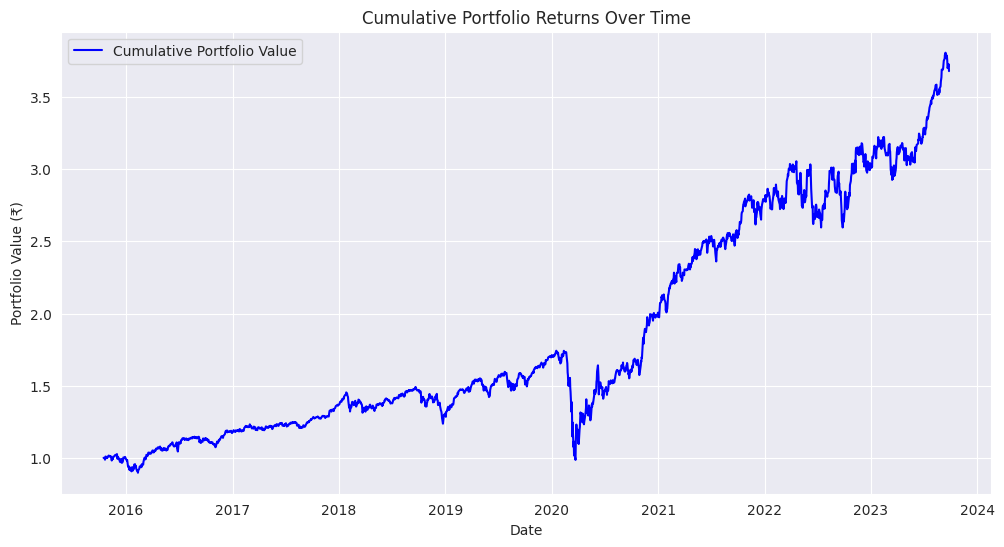

In [28]:
import numpy as np
import pandas as pd

cumulative_returns = pd.Series(1, index=df.index)  # Start at 1 (100%)

for i in range(len(momentum_df)):
    date = momentum_df.loc[i, 'Date']
    stocks = momentum_df.loc[i, 'Stocks']

    # Remove '_RSI' suffix from stock names
    stocks = [s.replace('_RSI', '') for s in stocks]

    # Get returns for the selected stocks
    try:
        stock_returns = df[stocks].pct_change().dropna()
    except KeyError as e:
        print(f"Error: Some stocks not found in df. Skipping this period.\n{e}")
        continue

    # Calculate equal-weighted portfolio return
    portfolio_ret = stock_returns.mean(axis=1)

    # Store returns
    portfolio_returns.loc[portfolio_ret.index, 'Portfolio Returns'] = portfolio_ret

# Fill NaN values with previous returns (handling missing cases)
portfolio_returns.fillna(0, inplace=True)  # Replace NaNs with 0% return

# Compute cumulative returns (portfolio value over time)
cumulative_returns = (1 + portfolio_returns['Portfolio Returns']).cumprod()

# Plot cumulative returns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label="Cumulative Portfolio Value", color='blue')
plt.xlabel("Date")
plt.ylabel("Portfolio Value (₹)")
plt.title("Cumulative Portfolio Returns Over Time")
plt.legend()
plt.grid(True)
plt.show()


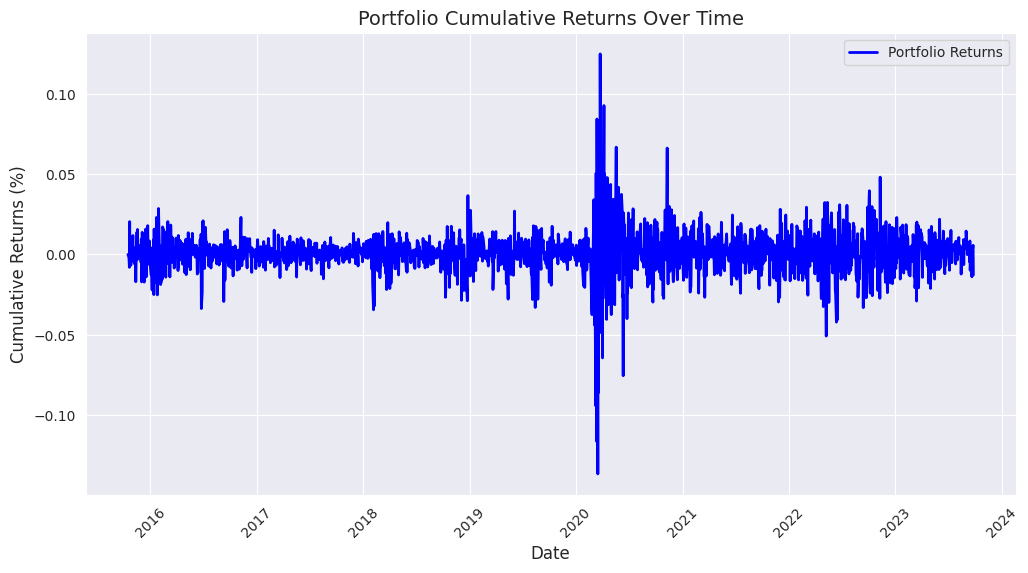

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("darkgrid")

# Plot portfolio cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns, label="Portfolio Returns", color="blue", linewidth=2)

# Formatting
plt.title("Portfolio Cumulative Returns Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Returns (%)", fontsize=12)
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [30]:
cumulative_returns.head()

,Portfolio Returns
Date,
2015-10-16,1.000000
2015-10-19,0.998458
2015-10-20,0.994775
2015-10-21,0.986795
2015-10-22,1.006998


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Define start and end dates
start_date = "2015-10-16"
end_date = cumulative_returns.index[-1]  # Last date of portfolio

# Fetch S&P 500 data from Yahoo Finance
sp500 = yf.download("^GSPC", start=start_date, end=end_date)

# Debug: Print available columns
print(sp500.head())

[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2015-10-16  2033.109985  2033.540039  2020.459961  2024.369995  3595430000
2015-10-19  2033.660034  2034.449951  2022.310059  2031.729980  3287320000
2015-10-20  2030.770020  2039.119995  2026.609985  2033.130005  3331500000
2015-10-21  2018.939941  2037.969971  2017.219971  2033.469971  3627790000
2015-10-22  2052.510010  2055.199951  2021.880005  2021.880005  4430850000


In [38]:
sp500.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2015-10-16,2033.109985,2033.540039,2020.459961,2024.369995,3595430000
2015-10-19,2033.660034,2034.449951,2022.310059,2031.729980,3287320000
2015-10-20,2030.770020,2039.119995,2026.609985,2033.130005,3331500000
2015-10-21,2018.939941,2037.969971,2017.219971,2033.469971,3627790000
2015-10-22,2052.510010,2055.199951,2021.880005,2021.880005,4430850000


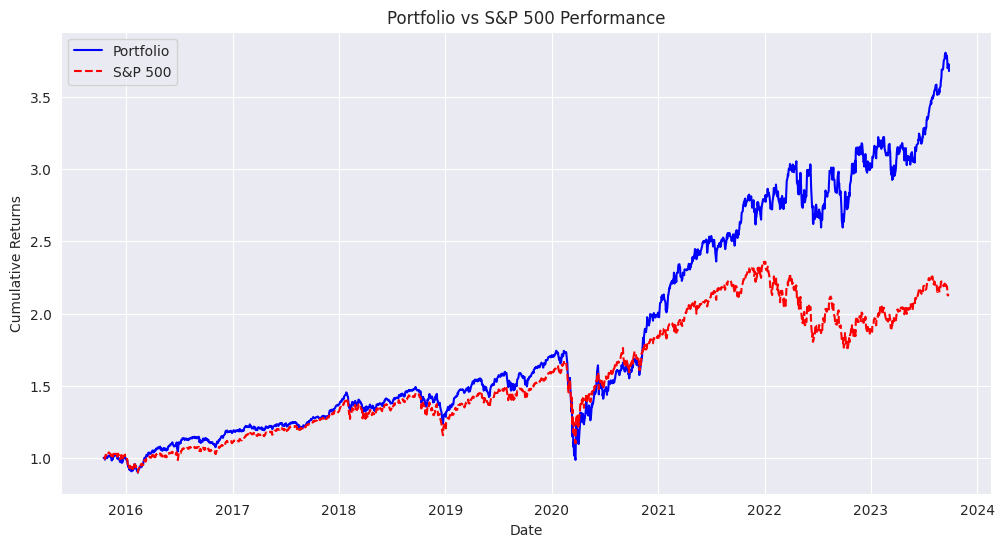

In [39]:

if 'Close' in sp500.columns:
    sp500_cumulative = sp500['Close'] / sp500['Close'].iloc[0]

# Normalize Portfolio Returns (Already starts at 1)
portfolio_cumulative = cumulative_returns / cumulative_returns.iloc[0]

# Plot Both
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cumulative, label="Portfolio", color='blue')
plt.plot(sp500_cumulative, label="S&P 500", color='red', linestyle="dashed")

# Labels & Title
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Portfolio vs S&P 500 Performance")
plt.legend()
plt.grid(True)
plt.show()


In [40]:
import numpy as np

# Compute Daily Returns
portfolio_returns = cumulative_returns.pct_change().dropna()

# Risk-Free Rate (Assume 5% annual risk-free return)
risk_free_rate = 0.05 / 252  # Convert annual to daily

# 1. Annualized Return
annualized_return = (cumulative_returns.iloc[-1] / cumulative_returns.iloc[0]) ** (252 / len(cumulative_returns)) - 1

# 2. Annualized Volatility (Standard Deviation of Returns)
annualized_volatility = portfolio_returns.std() * np.sqrt(252)

# 3. Sharpe Ratio (Risk-Adjusted Return)
sharpe_ratio = (annualized_return - 0.05) / annualized_volatility  # Subtract risk-free rate

# 4. Maximum Drawdown (MDD)
cumulative_max = cumulative_returns.cummax()  # Rolling maximum
drawdown = (cumulative_returns - cumulative_max) / cumulative_max
max_drawdown = drawdown.min()

# 5. Calmar Ratio (Return / Maximum Drawdown)
calmar_ratio = annualized_return / abs(max_drawdown)

# 6. Sortino Ratio (Only considers downside risk)
downside_returns = portfolio_returns[portfolio_returns < 0]  # Negative returns only
downside_volatility = downside_returns.std() * np.sqrt(252)
sortino_ratio = (annualized_return - 0.05) / downside_volatility

# Print all metrics
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")


Annualized Return: 17.85%
Annualized Volatility: 21.11%
Sharpe Ratio: 0.61
Max Drawdown: -43.42%
Calmar Ratio: 0.41
Sortino Ratio: 0.72


In [44]:
cumulative_returns.iloc[-1]

3.6795677270428797

In [45]:
sp500_cumulative.iloc[-1]

,2023-09-25
Ticker,
^GSPC,2.133402


In [ ]:
# Thank you